<a href="https://colab.research.google.com/github/OdysseusPolymetis/enssib_class/blob/main/3_Stylometry_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stylométrie et Apprentissage Machine**
---

Ici on va faire de la stylométrie un peu plus avancée, avec l'utilisation d'un moteur de prédiction SVM (supervisé) et une visualisation (non supervisée) avec UMAP. Il s'agit bien de deux méthodes différentes, mais comme on va le voir, les résultats obtenus sont similaires.

Deux méthodes donc différentes mais complémentaires :

- **SVM** : un **modèle de classification supervisée** → il apprend à **prédire l'auteur** d'un texte à partir de ses caractéristiques stylistiques (ex. fréquences de mots-outils, n-grammes, etc.).
- **UMAP** : une **méthode de réduction de dimension** → elle sert surtout à **visualiser** les textes en 2D (ou 3D) pour voir des proximités, des groupes, des “zones” (mais ce n'est pas un classifieur).

---


D'abord une petite cellule simple pour installer les paquets, s'il en manque.

In [ ]:
install_if_missing <- function(pkgs) {
  to_install <- pkgs[!pkgs %in% rownames(installed.packages())]
  if (length(to_install) > 0) install.packages(to_install, repos = "https://cloud.r-project.org")
}

In [ ]:
install_if_missing(c(
  "xml2", "stringr", "dplyr", "purrr", "readr", "ggplot2",
  "stylo", "uwot", "tibble","ggforce", "ggrepel"
))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Ici c'est l'import des libs.

In [ ]:
library(xml2)
library(stringr)
library(dplyr)
library(purrr)
library(readr)
library(ggplot2)
library(stylo)
library(uwot)
library(tibble)
library(ggforce)
library(ggrepel)

Les données que je vous fournis sont aussi disponibles sur l'article de Camps et Cafiero que nous avons déjà vu, ici : https://pmc.ncbi.nlm.nih.gov/articles/PMC6881153/
<br>Pour simplifier l'accès dans le notebook, je les ai mises sur mon dépôt personnel, mais je ne les ai pas produites.

In [ ]:
url <- "https://github.com/OdysseusPolymetis/digital_classics_course/raw/refs/heads/main/aax5489_Data_file_S2.7z"
download.file(url, "aax5489_Data_file_S2.7z", mode = "wb")

In [ ]:
S2_7Z <- "/content/aax5489_Data_file_S2.7z"

WORKDIR <- "/content/stylo_work"
dir.create(WORKDIR, showWarnings = FALSE, recursive = TRUE)

S2_DIR <- file.path(WORKDIR, "S2")
dir.create(S2_DIR, showWarnings = FALSE, recursive = TRUE)

In [ ]:
if (Sys.which("7z") == "") {
  system("apt-get update -qq && apt-get install -y -qq p7zip-full")
}

if (length(list.files(S2_DIR, all.files = TRUE, no.. = TRUE)) < 3) {
  cmd <- sprintf("7z x -y %s -o%s", shQuote(S2_7Z), shQuote(S2_DIR))
  system(cmd)
}

cat("S2 extrait dans:", S2_DIR, "\n")

S2 extrait dans: /content/stylo_work/S2 


Maintenant qu'on a extrait les données, on va fixer un peu les xml (fournir les namespaces etc). On va notamment extraire les formes des données, sans les noms propres (qui peuvent être un trop gros marqueur et qui peuvent fausser les résultats), et les stocker dans deux dossiers, un dossier d'entraînement, et un dossier de test. Les deux dossiers sont remplis aléatoirement, donc si vous utilisez ce notebook pour d'autres expériences, vous devrez mettre les auteurs certains dans le train, et les incertains dans le test.

In [ ]:
ns_tei <- c(
  tei = "http://www.tei-c.org/ns/1.0",
  txm = "http://textometrie.org/1.0"
)

La cellule qui suit sert à **trouver automatiquement** où se trouvent les fichiers XML dans l’arborescence de ton projet, puis à **compter** combien il y en a.

In [ ]:
xml_main_dir    <- list.dirs(S2_DIR, recursive = TRUE, full.names = TRUE) |>
  keep(~ grepl("xml_main$", .x)) |>
  head(1)

xml_control_dir <- list.dirs(S2_DIR, recursive = TRUE, full.names = TRUE) |>
  keep(~ grepl("xml_control$", .x)) |>
  head(1)

stopifnot(length(xml_main_dir) == 1, length(xml_control_dir) == 1)

xml_main_files <- list.files(xml_main_dir, pattern = "\\.xml$", full.names = TRUE)
xml_ctrl_files <- list.files(xml_control_dir, pattern = "\\.xml$", full.names = TRUE)

cat("XML main  :", length(xml_main_files), "\n")
cat("XML control:", length(xml_ctrl_files), "\n")

XML main  : 86 
XML control: 61 


Cette cellule définit une petite fonction réutilisable, `safe_child_text()`, qui sert à **récupérer le texte d'un élément XML** en évitant les erreurs quand l'élément n'existe pas.

In [ ]:
safe_child_text <- function(node, xpath, ns) {
  x <- xml_find_first(node, xpath, ns = ns)
  if (length(x) == 0) return(NA_character_)
  xml_text(x)
}

Cette fonction `extract_tokens()` lit un fichier XML (souvent TEI/TXM), récupère les mots, puis renvoie une **liste de tokens** prête à être utilisée pour la stylométrie.
<br>Et, si on le souhaite, **retirer les noms propres** (souvent très liés au contenu / personnages, donc potentiellement "bruit" pour attribuer un auteur).

In [ ]:
extract_tokens <- function(xml_file, drop_proper = TRUE) {
  doc <- read_xml(xml_file)
  w_nodes <- xml_find_all(doc, ".//tei:w", ns = ns_tei)
  if (length(w_nodes) == 0) return(character(0))

  form  <- vapply(w_nodes, safe_child_text, character(1), xpath = "./txm:form", ns = ns_tei)
  frpos <- vapply(w_nodes, safe_child_text, character(1), xpath = "./txm:ana[@type='frpos']", ns = ns_tei)

  ok <- !is.na(form) & nzchar(form)
  if (drop_proper) ok <- ok & !(frpos %in% "NOMpro")

  form[ok]
}

La cellule suivante avec la fonction `author_from_basename()` sert à **extraire l'auteur** depuis le nom du fichier (son "basename"), en supposant une convention de nommage du type : AUTEUR_TITRE.xml

In [ ]:
author_from_basename <- function(path) {
  b <- tools::file_path_sans_ext(basename(path))
  sub("_.*$", "", b)
}

La fonction `build_author_corpus()` transforme une liste de fichiers XML en un **corpus de fichiers texte (.txt)** organisés dans des dossiers par auteur :
<br>out_dir/
<br>CORNEILLEP/
<br>CORNEILLEP_ILLUSIONCOMIQUE.txt
<br>...
<br>ROTROU/
<br>ROTROU_SAINTGENEST.txt
<br>...

In [ ]:
build_author_corpus <- function(xml_files, out_dir, drop_proper = TRUE) {
  dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

  for (f in xml_files) {
    a <- author_from_basename(f)
    a_dir <- file.path(out_dir, a)
    dir.create(a_dir, showWarnings = FALSE, recursive = TRUE)

    tokens <- extract_tokens(f, drop_proper = drop_proper)
    if (length(tokens) < 10) next

    out_file <- file.path(a_dir, paste0(tools::file_path_sans_ext(basename(f)), ".txt"))
    writeLines(paste(tokens, collapse = " "), out_file, useBytes = TRUE)
  }

  invisible(out_dir)
}

In [ ]:
CORPUS_TXT_DIR <- file.path(WORKDIR, "corpus_txt_main_noPN")
if (!dir.exists(CORPUS_TXT_DIR) || length(list.files(CORPUS_TXT_DIR, recursive = TRUE)) < 50) {
  build_author_corpus(xml_main_files, CORPUS_TXT_DIR, drop_proper = TRUE)
}

cat("Corpus texte prêt:", CORPUS_TXT_DIR, "\n")


Corpus texte prêt: /content/stylo_work/corpus_txt_main_noPN 


La cellule suivante avec la fonction `make_stylo_split()` fabrique automatiquement deux ensembles de textes :

- **primary_set** = ensemble d'entraînement (*train*)  
- **secondary_set** = ensemble de test (*test*)

L'objectif est de pouvoir :
1) **entraîner** un modèle (ici SVM) sur le train,
2) **évaluer** ses performances sur des textes jamais vus (test).


*Paramètres de la fonction*

- `corpus_by_author_dir` : dossier où les textes sont déjà rangés par auteur (créé avant).
- `authors` : liste des auteurs à inclure.
- `out_dir` : dossier où écrire le nouveau split.
- `train_ratio` : proportion de textes envoyés au train (par défaut 70%).
- `seed` : graine aléatoire pour rendre le split **reproductible**.

---

In [ ]:
make_stylo_split <- function(corpus_by_author_dir,
                             authors,
                             out_dir,
                             train_ratio = 0.7,
                             seed = 42) {
  set.seed(seed)

  dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)
  dir.create(file.path(out_dir, "primary_set"), showWarnings = FALSE, recursive = TRUE)
  dir.create(file.path(out_dir, "secondary_set"), showWarnings = FALSE, recursive = TRUE)

  copied_train <- 0
  copied_test  <- 0

  for (a in authors) {
    a_dir <- file.path(corpus_by_author_dir, a)
    files <- list.files(a_dir, pattern = "\\.txt$", full.names = TRUE)
    if (length(files) < 3) {
      message("Pas assez de textes pour ", a, " (", length(files), "). On saute.")
      next
    }

    idx <- sample(seq_along(files))
    n_train <- max(2, floor(length(files) * train_ratio))
    train_files <- files[idx[1:n_train]]
    test_files  <- files[idx[(n_train + 1):length(files)]]

    file.copy(train_files, file.path(out_dir, "primary_set", basename(train_files)), overwrite = TRUE)
    file.copy(test_files,  file.path(out_dir, "secondary_set", basename(test_files)),  overwrite = TRUE)

    copied_train <- copied_train + length(train_files)
    copied_test  <- copied_test  + length(test_files)
  }

  cat("Copiés:", copied_train, "train /", copied_test, "test\n")
  invisible(out_dir)
}

In [ ]:
small_authors <- c("CORNEILLEP","CORNEILLET","MOLIERE","ROTROU","SCARRON")
STYLO_SMALL_DIR <- file.path(WORKDIR, "stylo_small")

In [ ]:
make_stylo_split(
  corpus_by_author_dir = CORPUS_TXT_DIR,
  authors = small_authors,
  out_dir = STYLO_SMALL_DIR,
  train_ratio = 0.7,
  seed = 42
)

Copiés: 30 train / 17 test


Après cette cellule, vous verrez que vous aurez plusieurs dossiers de créés dans le dossier `content`, et notamment `primary_set` et `secondary_set`. Dedans il y a les fichiers txt que nous aurons tirés des XML. Si vous souhaitez classer d'autres documents, remplacez les textes en suivant le même type de nommage de fichiers, et changez dans la cellule adéquate les noms des auteurs que vous voudrez comparer.

## **SVM**

### Idée générale
On représente chaque texte par un **vecteur de caractéristiques** (features).  
Exemple stylométrie : pour chaque texte, une liste de nombres (fréquences de mots, etc.).  
Chaque texte devient donc un **point** dans un espace de dimension élevée (souvent dizaines/centaines).

Le SVM cherche une **frontière de décision** qui sépare au mieux les classes (ici : les auteurs).  
La version la plus simple cherche une **droite** (en 2D), un **plan** (en 3D), ou plus généralement un **hyperplan** (en grande dimension, ici 2000).

Ce qui fait la "signature" du SVM :
- il ne cherche pas juste *une* séparation, il cherche celle qui **maximise la marge** (distance entre la frontière et les points les plus proches),
- les points “critiques” qui déterminent la frontière s’appellent les **support vectors**.

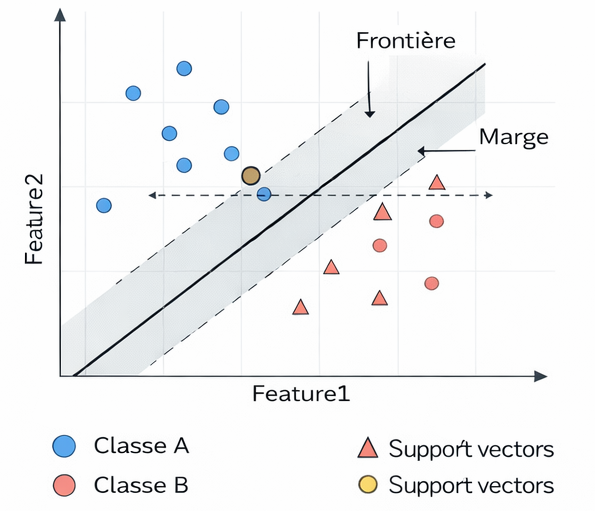

Imaginons 2 auteurs, et seulement 2 features pour simplifier.

Le SVM place la frontière pour **séparer** les deux groupes **en maximisant la marge**.

Ici on va ensuite lancer l'entraînement du moteur SVM. Vous pouvez changer le paramétrage si vous le souhaitez.

La fonction `run_stylo_svm()` exécute le cœur de l'expérience : **entraîner un classifieur SVM** sur le corpus *train* (primary_set) et **prédire** les auteurs des textes du *test* (secondary_set), en utilisant la librairie **stylo**.

Ici, `stylo::classify()` s'occupe de tout :
- construire la matrice de features (fréquences, n-grammes, etc.),
- entraîner le modèle,
- faire la validation croisée (si demandée),
- prédire les textes du test.

*Paramètres*

- `stylo_dir` : dossier qui contient `primary_set/` et `secondary_set/`.
- `analyzed.features` : type d'unités utilisées comme features :
  - `"w"` = mots,
  - `"c"` = caractères (très courant en stylométrie car robuste aux variations lexicales).
- `ngram.size` : taille des n-grammes (ici 3 → trigrammes de caractères si `analyzed.features = "c"`).
- `mfw` : **Most Frequent Words/features** : nombre de features conservées (ici 2000).
  - même si le nom contient “Words”, cela vaut aussi pour les n-grammes : on garde les 2000 plus fréquents.
- `cv_folds` : nombre de plis pour la **validation croisée** sur le train.
- `seed` : graine aléatoire pour rendre le résultat reproductible.

In [ ]:
run_stylo_svm <- function(stylo_dir,
                          analyzed.features = "c",
                          ngram.size = 3,
                          mfw = 2000,
                          cv_folds = 10,
                          seed = 42) {
  set.seed(seed)

  res <- stylo::classify(
    gui = FALSE,
    path = stylo_dir,
    training.corpus.dir = "primary_set",
    test.corpus.dir = "secondary_set",
    analyzed.features = analyzed.features,
    ngram.size = ngram.size,
    classification.method = "svm",
    mfw.min = mfw, mfw.max = mfw, mfw.incr = 0,
    culling.min = 0, culling.max = 0, culling.incr = 20,
    cv.folds = cv_folds
  )

  res
}

In [ ]:
res_small <- run_stylo_svm(STYLO_SMALL_DIR, ngram.size = 3, mfw = 2000, cv_folds = 10)

La cellule qui suit sert à **évaluer la qualité des prédictions** du SVM sur le jeu de test, avec deux outils classiques :

- une **matrice de confusion** (qui montre *qui est confondu avec qui*),
- une **accuracy** (proportion globale de bonnes prédictions).

In [ ]:
pred <- res_small$predicted
exp  <- res_small$expected

tab <- table(expected = exp, predicted = pred)
tab

acc <- sum(diag(tab)) / sum(tab)
acc

            predicted
expected     CORNEILLEP CORNEILLET MOLIERE ROTROU SCARRON
  CORNEILLEP         34          6       0      0       0
  CORNEILLET          0         38       2      0       0
  MOLIERE             1          0      39      0       0
  ROTROU             14          0       0      6       0
  SCARRON             9          0       2      0      19

[1] 0.8

La cellule suivante transforme la matrice de confusion en **proportions** (normalisées par ligne), puis l'affiche sous forme de **carte de chaleur**.  
C'est une visualisation qui montre, pour chaque auteur réel, **comment se répartissent les prédictions**.


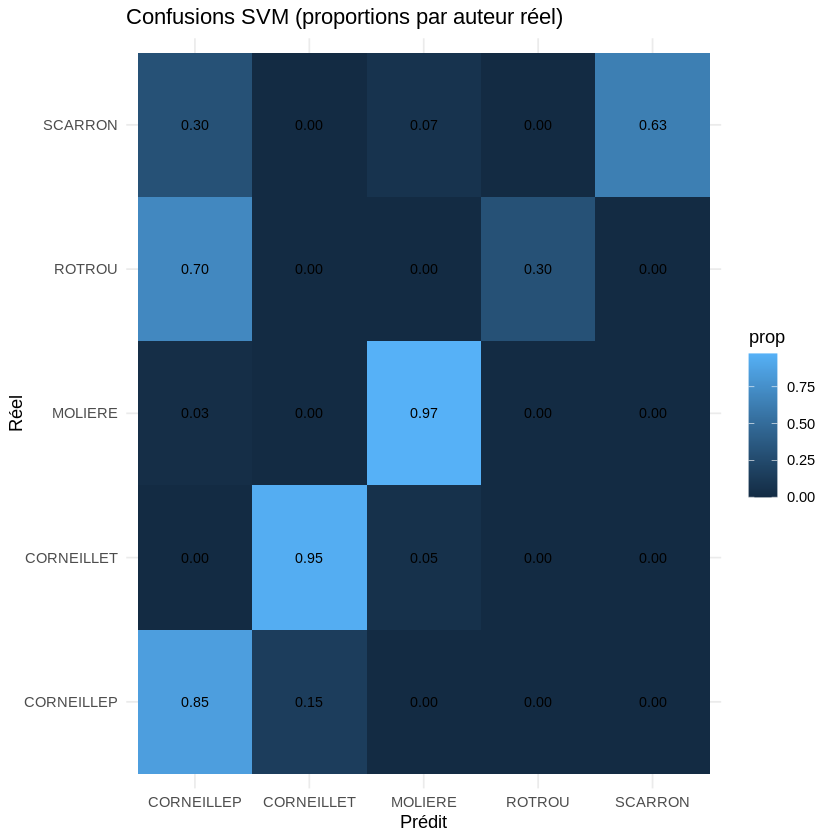

In [ ]:
tab_row <- prop.table(tab, margin = 1)

dfm <- as.data.frame(tab_row)
colnames(dfm) <- c("expected", "predicted", "prop")

ggplot(dfm, aes(x = predicted, y = expected, fill = prop)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f", prop)), size = 3) +
  theme_minimal() +
  labs(
    title = "Confusions SVM (proportions par auteur réel)",
    x = "Prédit", y = "Réel"
  )

Cette cellule construit un tableau lisible, texte par texte, pour savoir :

- quel fichier (ou texte) a été évalué,
- quel est l'auteur **réel** (*expected / gold*),
- quel est l'auteur **prédit** par le SVM,
- si la prédiction est **correcte** (`ok = TRUE/FALSE`).

C'est un complément très utile à la matrice de confusion : ici on descend au niveau des **cas individuels**.

In [ ]:
pred <- res_small$predicted
exp  <- res_small$expected

test_names <- rownames(res_small$frequencies.test.set)

In [ ]:
df_pred <- data.frame(
  text     = test_names,
  expected = as.character(exp),
  predicted = as.character(pred),
  ok = as.character(exp) == as.character(pred),
  stringsAsFactors = FALSE
)

print(df_pred)

                           text   expected  predicted    ok
1    CORNEILLEP_ILLUSIONCOMIQUE CORNEILLEP CORNEILLEP  TRUE
2        CORNEILLEP_PLACEROYALE CORNEILLEP CORNEILLEP  TRUE
3           CORNEILLEP_SUIVANTE CORNEILLEP CORNEILLEP  TRUE
4               CORNEILLEP_TITE CORNEILLEP CORNEILLEP  TRUE
5       CORNEILLET_AMOURALAMODE CORNEILLET CORNEILLET  TRUE
6    CORNEILLET_COMTESSEORGUEIL CORNEILLET CORNEILLET  TRUE
7       CORNEILLET_FESTINPIERRE CORNEILLET CORNEILLET  TRUE
8   CORNEILLET_ILLUSTRESENNEMIS CORNEILLET CORNEILLET  TRUE
9            MOLIERE_AMPHITRYON    MOLIERE    MOLIERE  TRUE
10              MOLIERE_ETOURDI    MOLIERE    MOLIERE  TRUE
11              MOLIERE_FACHEUX    MOLIERE    MOLIERE  TRUE
12            MOLIERE_MELICERTE    MOLIERE    MOLIERE  TRUE
13         ROTROU_BAGUEDELOUBLI     ROTROU CORNEILLEP FALSE
14                ROTROU_SOSIES     ROTROU     ROTROU  TRUE
15     SCARRON_GARDIENDESOIMEME    SCARRON CORNEILLEP FALSE
16              SCARRON_JODELET    SCARR

### **À retenir donc**
- **SVM = prédire** l’auteur à partir des features.
- Les **support vectors** sont les textes les plus "ambigus" qui gouvernent la séparation.
- Une **matrice de confusion** te dit *qui est confondu avec qui*.
---

## **UMAP**

(Uniform Manifold Approximation and Projection)

### Idée générale
UMAP sert à **projeter des données de grande dimension en 2D** pour les visualiser.

Important :
- UMAP **ne "découvre" pas des auteurs**, il **représente des proximités** selon tes features.
- Les axes UMAP1/UMAP2 **n'ont pas de signification interprétable**.
- Deux points proches en UMAP = textes **similaires dans l'espace des features** (surtout localement).

### Comment UMAP construit la carte
UMAP (très grossièrement) :
1) construit un **graphe des k plus proches voisins** (kNN) dans l'espace des features,
2) place ensuite les points en 2D pour **préserver au mieux ces voisinages** (les proches restent proches), tout en "dépliant" la structure globale.


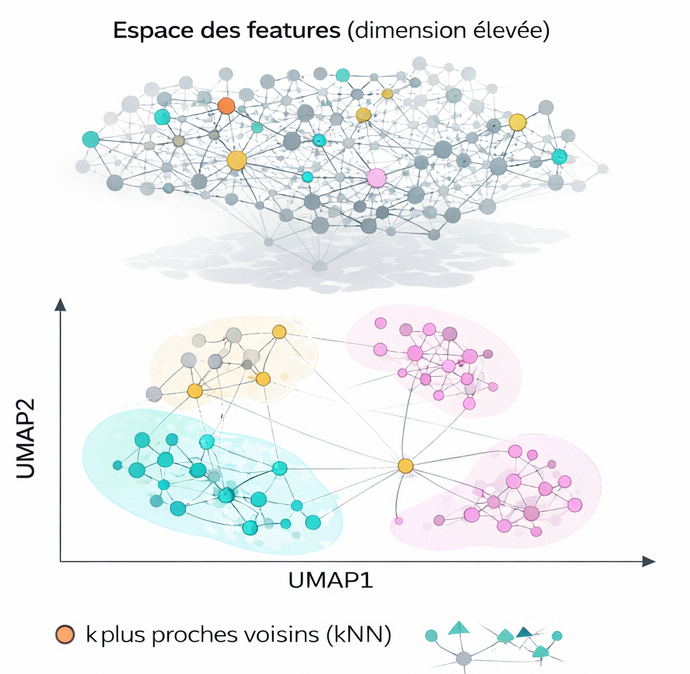

Avant de calculer une UMAP, il faut une matrice numérique où :
- chaque **ligne** = un texte,
- chaque **colonne** = une feature stylométrique (ex. trigrammes de caractères, mots fréquents, etc.),
- chaque **valeur** = la fréquence (ou un poids) de cette feature dans le texte.

`stylo::classify()` a déjà construit ces matrices pour nous. Cette cellule les extrait depuis l'objet résultat `res_small`.

In [ ]:
X_all   <- res_small$frequencies.both.sets
X_train <- res_small$frequencies.training.set
X_test  <- res_small$frequencies.test.set

Certaines fonctions (dont `umap()` / `uwot::umap()`) attendent une **matrice numérique** "pure".  
Or, les objets renvoyés par `stylo` peuvent être des matrices avec une structure particulière (attributs, classes) qui gênent certains packages.

Cette cellule "nettoie" les objets pour obtenir des matrices **standard** en `double`.

In [ ]:
X_all   <- as.matrix(unclass(X_all));   storage.mode(X_all)   <- "double"
X_train <- as.matrix(unclass(X_train)); storage.mode(X_train) <- "double"
X_test  <- as.matrix(unclass(X_test));  storage.mode(X_test)  <- "double"

Les algorithmes comme UMAP ne supportent pas les valeurs “non finies” dans la matrice de données.  
Cette cellule remplace donc par **0** toutes les valeurs problématiques.

In [ ]:
X_all[!is.finite(X_all)]     <- 0
X_train[!is.finite(X_train)] <- 0
X_test[!is.finite(X_test)]   <- 0

Pour interpréter une projection UMAP, on a besoin de **labels** : savoir quel point correspond à quel texte, quel auteur, et s'il vient du train ou du test.

Cette cellule construit une table `meta` qui associe à chaque texte :
- son identifiant (`text`),
- le **set** : `train` ou `test`,
- l'auteur **réel** (*gold*), déduit du nom.

In [ ]:
meta <- tibble(text = rownames(X_all)) |>
  mutate(
    set  = ifelse(text %in% rownames(X_train), "train", "test"),
    gold = factor(str_replace(text, "_.*$", ""))
  )

Un classifieur supervisé (comme le SVM) a besoin de deux choses pour apprendre :

1) une matrice de features `X_train` (déjà construite),
2) un vecteur d'étiquettes `y_train` qui indique, pour chaque texte du train, **la classe à prédire** (ici : l'auteur).

Cette cellule fabrique ce vecteur d'étiquettes à partir des noms de fichiers/textes.

In [ ]:
y_train <- factor(str_replace(rownames(X_train), "_.*$", ""))

Ici, on entraîne explicitement un modèle **SVM** avec le package `e1071`, à partir :

- `X_train` : la matrice de features (un texte = une ligne),
- `y_train` : les étiquettes d'auteur (un auteur = une classe).

Ce SVM sera ensuite utilisé pour prédire l'auteur de chaque texte (notamment ceux du test).
<br>On réentraîne ici un SVM avec e1071 non pas pour "faire mieux" que stylo, mais pour obtenir un objet modèle R standard (avec predict(), scores de décision, etc.) et pouvoir analyser finement les cas ambigus.

In [ ]:
svm_model <- e1071::svm(
  x = X_train,
  y = y_train,
  kernel = "linear",
  scale = FALSE
)

In [ ]:
pred_test <- predict(svm_model, X_test)

La cellule suivante prépare un petit tableau (`pred_df`) qui associe à chaque texte du **jeu de test** :

- son identifiant (`text`),
- l'auteur **prédit** (`pred`).

Ce format "long" est pratique pour ensuite :
- fusionner ces prédictions avec les métadonnées (`meta`),
- calculer `ok` (vrai/faux),
- colorer/annoter l'UMAP selon les erreurs.

In [ ]:
pred_df <- tibble(
  text = rownames(X_test),
  pred = factor(as.character(pred_test), levels = levels(meta$gold))
)

La cellule suivante enrichit la table `meta` avec les prédictions du SVM (pour le test) et crée une colonne `ok` qui indique si chaque point est correctement classé.

In [ ]:
meta <- meta |>
  left_join(pred_df, by = "text") |>
  mutate(ok = ifelse(set == "test", pred == gold, TRUE))

La cellule qui suit fait deux choses :

1) elle calcule une projection **UMAP en 2 dimensions** à partir des features stylométriques,
2) elle ajoute les coordonnées UMAP (`UMAP1`, `UMAP2`) dans un dataframe (`df`) qui contient aussi les labels (auteur, train/test, etc.).

In [ ]:
set.seed(42)
emb <- uwot::umap(X_all, n_neighbors = 15, min_dist = 0.1)

df <- meta |>
  mutate(
    UMAP1 = emb[,1],
    UMAP2 = emb[,2]
  )

Vient ensuite la projection UMAP calculée précédemment.  
Chaque point correspond à un **texte**, placé en 2D selon sa similarité stylistique (dans l'espace des features).

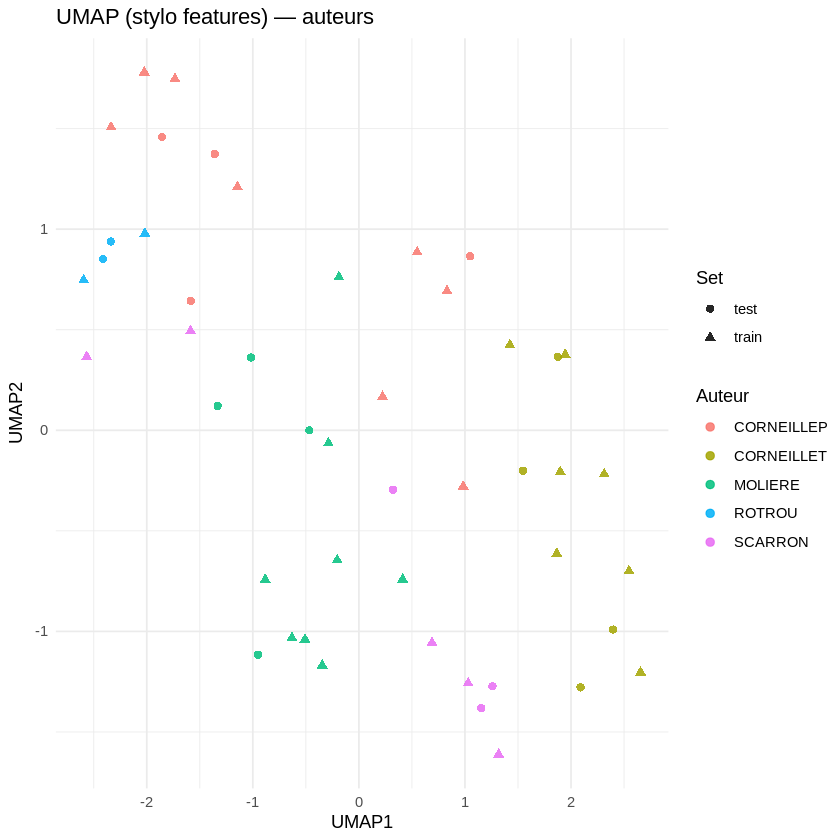

In [ ]:
ggplot(df, aes(UMAP1, UMAP2, color = gold, shape = set)) +
  geom_point(alpha = 0.85, size = 2) +
  theme_minimal() +
  labs(title = "UMAP (stylo features) — auteurs", color = "Auteur", shape = "Set")

La suite utilise la même projection UMAP (mêmes coordonnées `UMAP1/UMAP2`), mais au lieu de colorer par auteur, elle colore les points selon `ok` :

- `ok = TRUE` : prédiction correcte (sur le test),
- `ok = FALSE` : prédiction incorrecte (sur le test).

C'est une visualisation très efficace pour repérer **où se situent les erreurs** dans l'espace stylométrique.

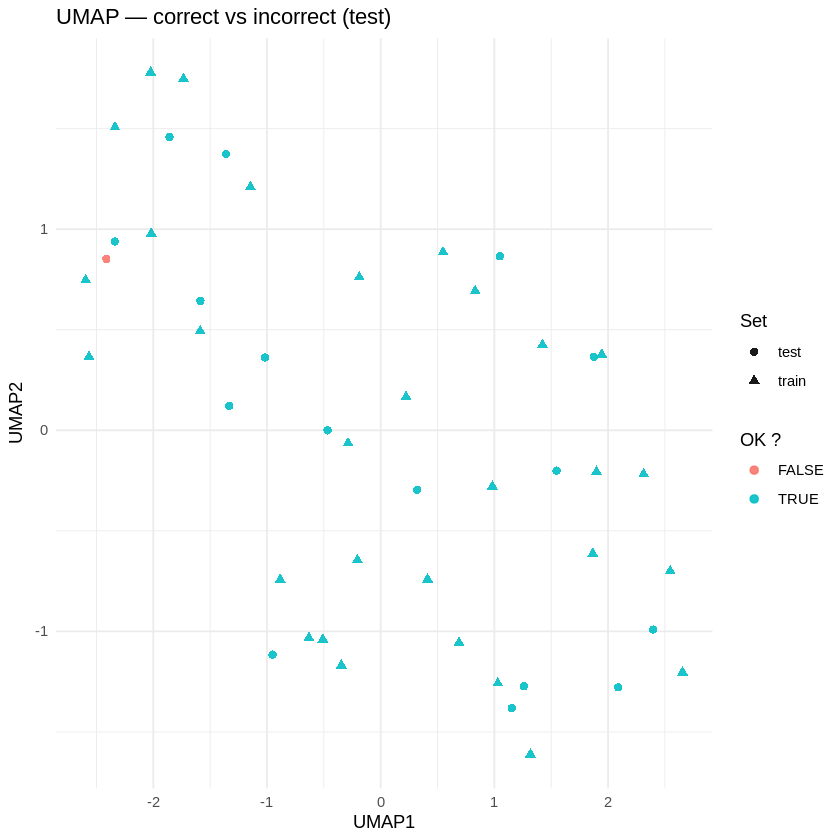

In [ ]:
ggplot(df, aes(UMAP1, UMAP2)) +
  geom_point(aes(color = ok, shape = set), alpha = 0.9, size = 2) +
  theme_minimal() +
  labs(title = "UMAP — correct vs incorrect (test)", color = "OK ?", shape = "Set")

In [ ]:
test_df <- df |> filter(set == "test")

table(gold = test_df$gold, pred = test_df$pred)
mean(test_df$ok, na.rm = TRUE)

            pred
gold         CORNEILLEP CORNEILLET MOLIERE ROTROU SCARRON
  CORNEILLEP          4          0       0      0       0
  CORNEILLET          0          4       0      0       0
  MOLIERE             0          0       4      0       0
  ROTROU              1          0       0      1       0
  SCARRON             0          0       0      0       3

[1] 0.9411765

Sur un nuage de points, il n'est pas toujours facile de "voir" les clusters.  
Cette cellule ajoute une **enveloppe** (un contour) autour des points de chaque auteur, ce qui rend les groupes beaucoup plus lisibles.

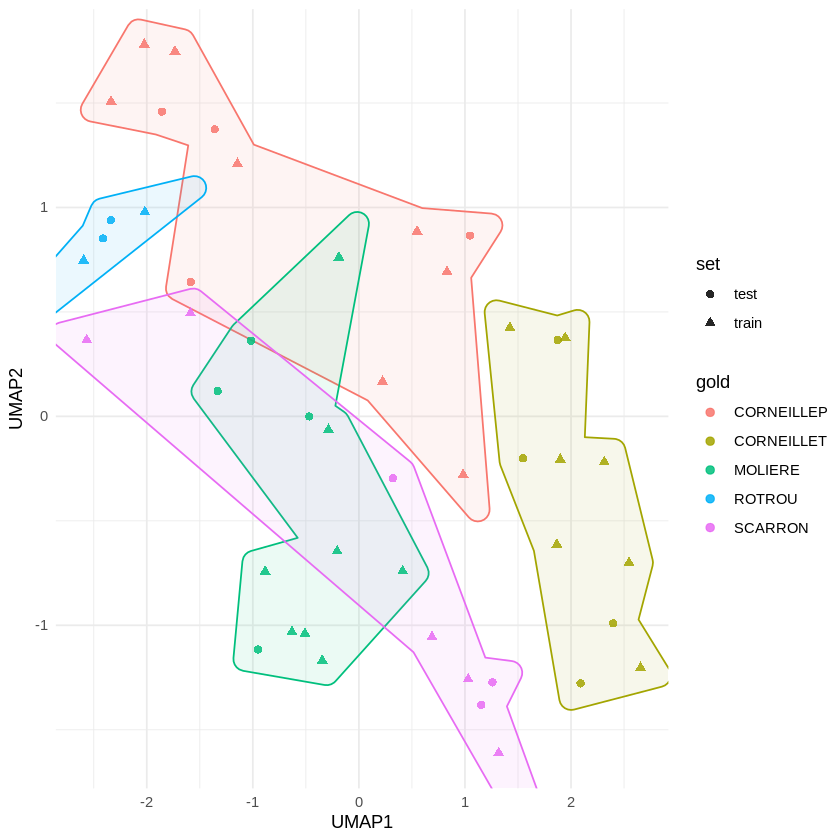

In [ ]:
ggplot(df, aes(UMAP1, UMAP2, color = gold)) +
  ggforce::geom_mark_hull(aes(fill = gold), alpha = 0.08, show.legend = FALSE) +
  geom_point(aes(shape = set), alpha = 0.85, size = 2) +
  theme_minimal()

Cette cellule identifie les textes du **test** mal classés (`ok == FALSE`) puis les **surligne** sur la carte UMAP et ajoute une **étiquette** indiquant la confusion :

> `auteur réel (gold) → auteur prédit (pred)`

C'est une visualisation plus claire : on voit à la fois
- la structure des groupes (hulls par auteur),
- et **exactement quels textes** posent problème, et **comment**.

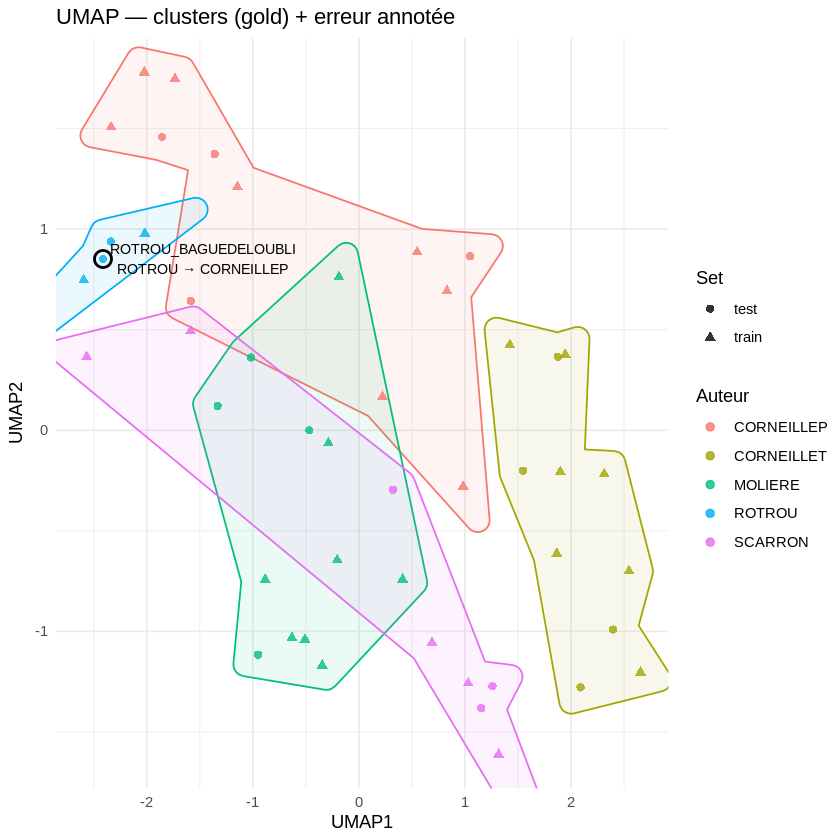

In [ ]:
err <- df |> dplyr::filter(set == "test", ok == FALSE)

ggplot(df, aes(UMAP1, UMAP2, color = gold)) +
  ggforce::geom_mark_hull(aes(fill = gold), alpha = 0.08, show.legend = FALSE) +
  geom_point(aes(shape = set), alpha = 0.8, size = 2) +
  geom_point(data = err, inherit.aes = FALSE,
             aes(UMAP1, UMAP2), shape = 21, size = 4,
             stroke = 1.2, color = "black", fill = NA) +
  ggrepel::geom_text_repel(
    data = err, inherit.aes = FALSE,
    aes(UMAP1, UMAP2, label = paste0(text, "\n", gold, " → ", pred)),
    size = 3, show.legend = FALSE
  ) +
  theme_minimal() +
  labs(title = "UMAP — clusters (gold) + erreur annotée", color = "Auteur", shape = "Set")

Cette figure se concentre uniquement sur le **jeu de test** et code simultanément :

- la **vérité terrain** (*gold*) par la **couleur**,
- la **prédiction du SVM** (*pred*) par la **forme**.

C'est une visualisation très directe des erreurs :  
une erreur apparaît quand **la forme ne correspond pas à la couleur**.

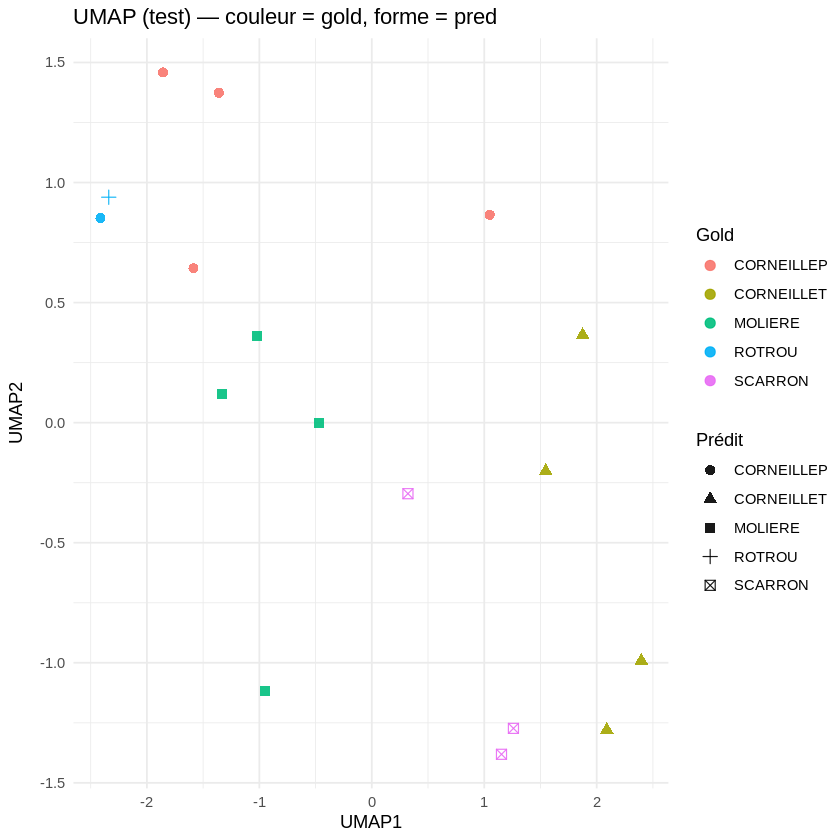

In [ ]:
test_df <- df |> dplyr::filter(set == "test")

ggplot(test_df, aes(UMAP1, UMAP2, color = gold, shape = pred)) +
  geom_point(alpha = 0.9, size = 2.5) +
  theme_minimal() +
  labs(title = "UMAP — couleur = gold, forme = pred",
       color = "Gold", shape = "Prédit")